# 写在前面
TrOCR原论文,预训练了6.8亿的人造数据，算力有限训不动(试过,没大量数据跑不起来)，因此做第二阶段微调。

然后huggingface有提供一阶段的参数。但是一阶段效果就很好了。因此这里将使用trocr的印刷体版本训练成手写字版本

这里数据好像给的太慢了,导致训练时间长，可以增加num_proc在datasets.map中以及trainingArgument中设置num_work。

jupyter在windows中存在多进程bug，所以这里没有实现。在mac和linux环境都是可以直接在jupyter中调用

看了很多实现，都没有实现动态padding，这里的代码实现了动态padding。


In [1]:
from datasets import load_dataset, concatenate_datasets

d:\software\anaconda\envs\global_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
raw_dataset = load_dataset("priyank-m/IAM_words_text_recognition")
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 69190
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 23064
    })
    val: Dataset({
        features: ['image', 'text'],
        num_rows: 23064
    })
})

In [3]:
val_raw_dataset = raw_dataset.pop("val")
raw_dataset["train"] = concatenate_datasets([raw_dataset["train"], val_raw_dataset])
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 92254
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 23064
    })
})

In [4]:
sample_dataset = raw_dataset["train"].select(range(10))
sample_dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 10
})

In [5]:
test_data = sample_dataset[0]
test_data

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=279x64>,
 'text': 'almost'}

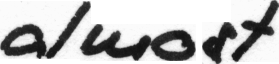

In [6]:
test_image = test_data["image"]
test_image

In [7]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

In [8]:
checkpoint = "microsoft/trocr-small-printed"
processor = TrOCRProcessor.from_pretrained(checkpoint)
model = VisionEncoderDecoderModel.from_pretrained(checkpoint)

# 补一下 好像不在模型自身的config decoder里有
model.config.decoder_start_token_id = processor.tokenizer.eos_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.48.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared d

In [9]:
def map_function(examples):
    origin_image_list = examples["image"]
    origin_text_list = examples["text"]
    
    image_list = []
    text_list = []
    for image, text in zip(origin_image_list, origin_text_list):
        image = image.convert("RGB")
        image_list.append(image)
        text_list.append(text)
    #BUG processor.tokenizer.bos_token != decoder_start_token 这个放在DataCollator中实现
    return processor(images=image_list, text=text_list)  

In [10]:
tokenizer_sample_dataset = sample_dataset.map(map_function, batched=True)
tokenizer_sample_dataset

Dataset({
    features: ['image', 'text', 'pixel_values', 'labels'],
    num_rows: 10
})

In [11]:
import torch
from dataclasses import dataclass
from transformers import default_data_collator
from typing import Any, List, Dict, Union

@dataclass
class DataCollatorForOCR:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor ([`WhisperProcessor`])
            The processor used for processing the data.
        decoder_start_token_id (`int`)
            The begin-of-sentence of the decoder.

    """

    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        model_input_name = self.processor.model_input_names[0]
        input_features = [{model_input_name: feature[model_input_name]} for feature in features]
        # 去掉process.tokenizer.bos_token_id  模型内部会给他补上 decoder_start_token_id 这里补也行 没必要
        label_features = [{"input_ids": feature["labels"][1:]} for feature in features]

        batch = default_data_collator(input_features, return_tensors="pt")

        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [12]:
from torch.utils.data import DataLoader

collate_fn = DataCollatorForOCR(processor, model.decoder.config.decoder_start_token_id)
dataloader = DataLoader(tokenizer_sample_dataset, batch_size=2, collate_fn=collate_fn)

for item in dataloader:
    pixel_values = item["pixel_values"]
    labels = item["labels"]
    print(pixel_values.size())
    print(labels.size())
    print(labels)
    break

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


torch.Size([2, 3, 384, 384])
torch.Size([2, 2])
tensor([[471,   2],
        [ 16,   2]])


In [13]:
tokenizer_datasets = raw_dataset.map(map_function, batched=True, remove_columns=raw_dataset["train"].column_names)
tokenizer_datasets

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 92254
    })
    test: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 23064
    })
})

In [14]:
import wandb
import evaluate
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, EvalPrediction

wandb.init(project="trocr_stage2")
accuracy = evaluate.load("accuracy")

def eval_function(eval_prediction:EvalPrediction):
    predictions = eval_prediction.predictions
    label_ids = eval_prediction.label_ids
    acc = accuracy.compute(references=label_ids, predictions=predictions)
    return acc

#! 因为动态padding,很有可能训练过程中 爆显存
train_args = Seq2SeqTrainingArguments(
    output_dir = "output/trocr_stage2",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    warmup_steps=1000,
    num_train_epochs=3,
    lr_scheduler_type="cosine",
    logging_steps=10,
    logging_first_step=True,
    logging_strategy="steps",
    eval_steps=500,
    eval_strategy="steps",
    save_strategy="epoch",
    save_safetensors=True,
    bf16=True,
    report_to="wandb"  # 如果不想用wandb 就改成tensorboard
)
trainer = Seq2SeqTrainer(
    model=model,
    args=train_args,
    data_collator=collate_fn,
    train_dataset=tokenizer_datasets["train"],
    eval_dataset=tokenizer_datasets["test"],
    compute_metrics=eval_function,
    processing_class=processor,
    
)

wandb: Currently logged in as: yizhen-ciao (yizhen-ciao-student). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [15]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 16.84 GiB. GPU 0 has a total capacity of 24.00 GiB of which 0 bytes is free. Of the allocated memory 24.09 GiB is allocated by PyTorch, and 13.18 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

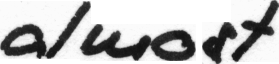

In [17]:
test_image

In [19]:
test_image = test_image.convert("RGB")
pixel_values = processor(images=test_image, return_tensors="pt")["pixel_values"]
pixel_values

tensor([[[[1.0000, 1.0000, 1.0000,  ..., 0.8039, 0.9216, 0.9608],
          [1.0000, 1.0000, 1.0000,  ..., 0.7882, 0.9216, 0.9608],
          [1.0000, 1.0000, 1.0000,  ..., 0.7725, 0.9137, 0.9529],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 0.8039, 0.9216, 0.9608],
          [1.0000, 1.0000, 1.0000,  ..., 0.7882, 0.9216, 0.9608],
          [1.0000, 1.0000, 1.0000,  ..., 0.7725, 0.9137, 0.9529],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 0.8039, 0.9216, 0.9608],
          [1.0000, 1.0000, 1.0000,  ..., 0.7882, 0.9216, 0.9608],
          [1.0000, 1.0000, 1.0000,  ..., 0

In [21]:
answer_token = model.generate(pixel_values.to(model.device))
answer_token

tensor([[  2, 471,   2]], device='cuda:0')

In [22]:
processor.batch_decode(answer_token)

['</s> almost</s>']